In [4]:
import pandas as pd
import numpy as np

In [5]:
weather = pd.read_csv(
    "https://raw.githubusercontent.com/zonination/weather-us/master/nyc.csv",
    parse_dates=["Date"],
).drop("Unnamed: 0", axis=1)
s = weather["PrecipitationIn"].replace({"T": 0}).astype(np.float32)
weather["PrecipitationIn"] = s.where(s < 5, 0)

nyc = pd.read_csv(
    "../NYCArrests.csv",
    usecols=[
        "ARREST_DATE",
        "PD_DESC",
        "OFNS_DESC",
        "ARREST_BORO",
        "AGE_GROUP",
        "PERP_SEX",
        "PERP_RACE",
        "Latitude",
        "Longitude",
    ],
    parse_dates=["ARREST_DATE"],
    cache_dates=True,
)
sp500 = pd.read_csv("../S&P500.csv", parse_dates=["Date"])

In [6]:
nyc["ARREST_DATE"].describe()
sp500["Date"].describe()
nyc["ARREST_DATE"].groupby(nyc["ARREST_DATE"].dt.year).size().mean()
sp500["Date"].groupby(sp500["Date"].dt.year).size().mean()
weather["Date"].groupby(weather["Date"].dt.year).size().mean()

361.1764705882353

In [7]:
nyc["ARREST_BORO"].value_counts()
# K is Brooklyn

K    1334914
M    1303786
B    1097367
Q     895903
S     166361
Name: ARREST_BORO, dtype: int64

In [8]:
exploded = nyc["PD_DESC"].str.split(",").explode()

In [9]:
exploded1 = exploded.str.replace("\d+", "").str.strip()

In [10]:
exploded2 = (
    exploded1.value_counts()
    .dropna()
    .reset_index()
    .rename({"index": "Classification", "PD_DESC": "Number of Instances"}, axis=1)
)

In [11]:
exploded3 = exploded2[
    (~exploded2["Classification"].str.contains("UNCLASSIFIED"))
    & (exploded2["Classification"].str.len() > 2)
]

In [12]:
exploded3.loc[:20].to_csv("counts_of_crimes.csv", index=False)

In [35]:
df = pd.read_csv("../NYCArrestsOriginal.csv")

In [13]:
to_merge1 = sp500[["Date", "Close", "Open", "Volume"]]
to_merge2 = (
    nyc["ARREST_DATE"]
    .value_counts()
    .reset_index(name="Num Arrests")
    .rename({"index": "Date"}, axis=1)
)
to_merge3 = weather[
    ["Date", "Mean.TemperatureF", "PrecipitationIn", "Events", "season"]
]

In [14]:
daily = to_merge1.merge(to_merge2).merge(to_merge3)

In [15]:
daily["Year"] = daily["Date"].dt.year
daily["Week"] = daily["Date"].dt.week
daily["Month"] = daily["Date"].dt.month

In [16]:
weekly = daily.groupby(["Year", "Week"]).mean().reset_index()

In [17]:
daily.groupby(daily["Date"].dt.year).size()

Date
2006    251
2007    251
2008    253
2009    252
2010    252
2011    252
2012    250
2013    252
2014    252
2015    252
dtype: int64

In [49]:
daily.to_csv("daily.csv", index=False)
weekly.to_csv("weekly.csv", index=False)

In [33]:
daily["Events"].str.split("-").explode().unique()

array(['Rain', nan, 'Fog', 'Snow', 'Thunderstorm'], dtype=object)

1 degree = 111 km

.1 degree = 11.1 km

.01 degree = 1.11 km

.001 degree = .111 km  = 111m

In [18]:
precision = 1000
nyc["RoundedLat"] = (nyc["Latitude"] * precision).round() / precision
nyc["RoundedLong"] = (nyc["Longitude"] * precision).round() / precision

In [47]:
to_graph = (
    nyc.groupby(["RoundedLat", "RoundedLong"]).size().reset_index(name="Count").dropna()
)
to_graph = to_graph[to_graph["RoundedLat"] < 41]
to_graph["bins"] = pd.qcut(to_graph["Count"], q=15, labels=False)
to_graph.columns

Index(['RoundedLat', 'RoundedLong', 'Count', 'bins'], dtype='object')

In [45]:
"pk.eyJ1IjoiYXNkZmZhIiwiYSI6ImNqeTdwMHRjNDAxc3ozZHBob240ZWMwd3UifQ.7YZDqSZ_EZx7-78pnR0v_g"

'pk.eyJ1IjoiYXNkZmZhIiwiYSI6ImNqeTdwMHRjNDAxc3ozZHBob240ZWMwd3UifQ.7YZDqSZ_EZx7-78pnR0v_g'

In [48]:
to_graph.to_csv("map.csv", index=False)

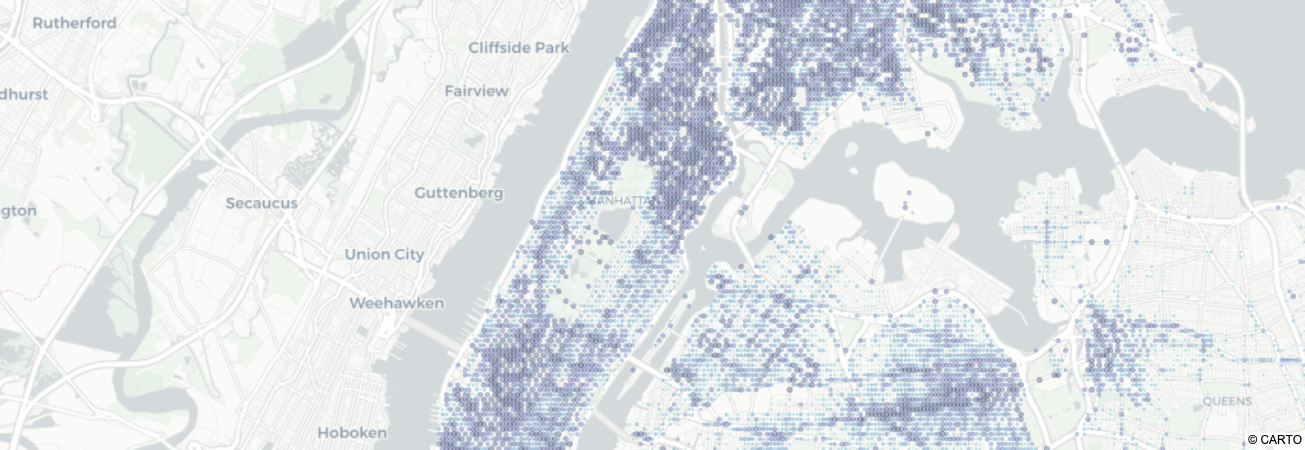

In [62]:
import plotly.graph_objects as go

fig = go.Figure(
    go.Scattermapbox(
        lat=to_graph["RoundedLat"],
        lon=to_graph["RoundedLong"],
        marker={
            "size": to_graph["bins"] / 2,
            "color": to_graph["bins"],
            "colorscale": "YlGnBu",
            "opacity": 0.3,
        },
    ),
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox={"center": {"lat": 40.7, "lon": -74}, "zoom": 9},
)
fig.show()